$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 5: Convolutional Architecture Experiments
<a id=part5></a>

In this part we will explore convolution networks and the effects of their architecture on accuracy. We'll use our deep CNN implementation and perform various experiments on it while varying the architecture. Then we'll implement our own custom architecture to see whether we can get high classification results on a large subset of CIFAR-10.

Training will be performed on GPU.

In [1]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

## Experimenting with model architectures
<a id=part5_3></a>

We will now perform a series of experiments that train various model configurations on a part of the CIFAR-10 dataset.

To perform the experiments, you'll need to use a machine with a GPU since training time might be too long otherwise.


### Note about running on GPUs

Here's an example of running a forward pass on the GPU
(assuming you're running this notebook on a GPU-enabled machine).

In [3]:
from hw2.cnn import ResNet

net = ResNet(
    in_size=(3,100,100), out_classes=10, channels=[32, 64]*3,
    pool_every=4, hidden_dims=[100]*2,
    pooling_type='avg', pooling_params=dict(kernel_size=2),
)
net = net.to(device)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).unsqueeze(0)
test_image = test_image.to(device)

test_out = net(test_image)

Notice how we called `.to(device)` on **both** the model and the input tensor.
Here the `device` is a `torch.device` object that we created above. If an nvidia GPU is available on the machine you're running this on, the `device` will be `'cuda'`. When you run `.to(device)` on a model, it recursively goes over all the model parameter tensors and copies their memory to the GPU. Similarly, calling `.to(device)` on the input image also copies it.

In order to train on a GPU, you need to make sure to move **all** your tensors to it. You'll get errors if you try to mix CPU and GPU tensors in a computation.

In [4]:
print(f'This notebook is running with device={device}')
print(f'The model parameter tensors are also on device={next(net.parameters()).device}')
print(f'The test image is also on device={test_image.device}')
print(f'The output is therefore also on device={test_out.device}')

This notebook is running with device=cpu
The model parameter tensors are also on device=cpu
The test image is also on device=cpu
The output is therefore also on device=cpu


### Notes on using course servers

First, please read the [course servers guide](https://vistalab-technion.github.io/cs236781/assignments/hpc-servers) carefully.

To run the experiments on the course servers, you can use the `py-sbatch.sh` script directly to perform a single experiment run in batch mode (since it runs python once), or use the `srun` command to do a single run in interactive mode. For example, running a single run of experiment 1 interactively (after `conda activate` of course):

```shell
srun -c 2 --gres=gpu:1 --pty python -m hw2.experiments run-exp -n test -K 32 64 -L 2 -P 2 -H 100
```

To perform multiple runs in batch mode with `sbatch` (e.g. for running all the configurations of an experiments), you can create your own script based on `py-sbatch.sh` and invoke whatever commands you need within it.

Don't request more than **2 CPU** cores and **1 GPU** device for your runs. The code won't be able to utilize more than that anyway, so you'll see no performance gain if you do. It will only cause delays for other students using the servers.

### General notes for running experiments

- You can run the experiments on a different machine (e.g. the course servers) and copy the results (files)
  to the `results` folder on your local machine.
  This notebook will only display the results, not run the actual experiment code (except for a demo run).
- It's important to give each experiment run a name as specified by the notebook instructions later on.
  Each run has a `run_name` parameter that will also be the base name of the results file which this 
  notebook will expect to load.
- You will implement the code to run the experiments in the `hw2/experiments.py` module.
  This module has a CLI parser so that you can invoke it as a script and pass in all the
  configuration parameters for a single experiment run.
- You should use `python -m hw2.experiments run-exp` to run an experiment, and **not**
  `python hw2/experiments.py run-exp`, regardless of how/where you run it.

### Experiment 1: Network depth and number of filters

In this part we will test some different architecture configurations based on our `CNN` and `ResNet`.
Specifically, we want to try different depths and number of features to see the effects these parameters have on the model's performance.

To do this, we'll define two extra hyperparameters for our model, `K` (`filters_per_layer`) and `L` (`layers_per_block`).
- `K` is a list, containing the number of filters we want to have in our conv layers.
- `L` is the number of consecutive layers with the same number of filters to use.

For example, if `K=[32, 64]` and `L=2` it means we want two conv layers with 32 filters followed by two conv layers with 64 filters. If we also use `pool_every=3`, the feature-extraction part of our model will be:

    Conv(X,32)->ReLu->Conv(32,32)->ReLU->Conv(32,64)->ReLU->MaxPool->Conv(64,64)->ReLU
    
We'll try various values of the `K` and `L` parameters in combination and see how each architecture trains. **All other hyperparameters are up to you**, including the choice of the optimization algorithm, the learning rate, regularization and architecture hyperparams such as `pool_every` and `hidden_dims`. Note that you should select the `pool_every` parameter wisely per experiment so that you don't end up with zero-width feature maps.

You can try some short manual runs to determine some good values for the hyperparameters or implement cross-validation to do it. However, the **dataset size** you test on should be large. If you limit the number of batches, make sure to use at least 30000 training images and 5000 validation images.

The important thing is that you state what you used, how you decided on it, and explain your results based on that.

First we need to write some code to run the experiment.

**TODO**:
1. Implement the `cnn_experiment()` function in the `hw2/experiments.py` module.
1. If you haven't done so already, it would be an excellent idea to implement the **early stopping** feature of the `Trainer` class.

The following block tests that your implementation works. It's also meant to show you that each experiment run creates a result file containing the parameters to reproduce and the `FitResult` object for plotting.

Files already downloaded and verified
Files already downloaded and verified
--- EPOCH 1/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

--- EPOCH 2/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

--- EPOCH 3/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

--- EPOCH 4/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

--- EPOCH 5/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

--- EPOCH 6/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

--- EPOCH 7/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

--- EPOCH 8/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

--- EPOCH 9/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

--- EPOCH 10/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/2 [00:00<?, ?it/s]

*** Output file ./results/test_run_L1_K32-64.json written
experiment config:  {'run_name': 'test_run', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'layers_per_block': 1, 'pool_every': 1, 'hidden_dims': [100], 'model_type': 'resnet', 'stride': 1, 'padding': 1, 'kernel_size': 3, 'dilation': 1, 'pooling_kernel_size': 2, 'pooling_stride': 2, 'lrelu_slope': 0.01, 'activation_type': 'lrelu', 'dropout': 0.1, 'batchnorm': False, 'bottleneck': False, 'amsgrad': False, 'kw': {}, 'filters_per_layer': [32, 64]}


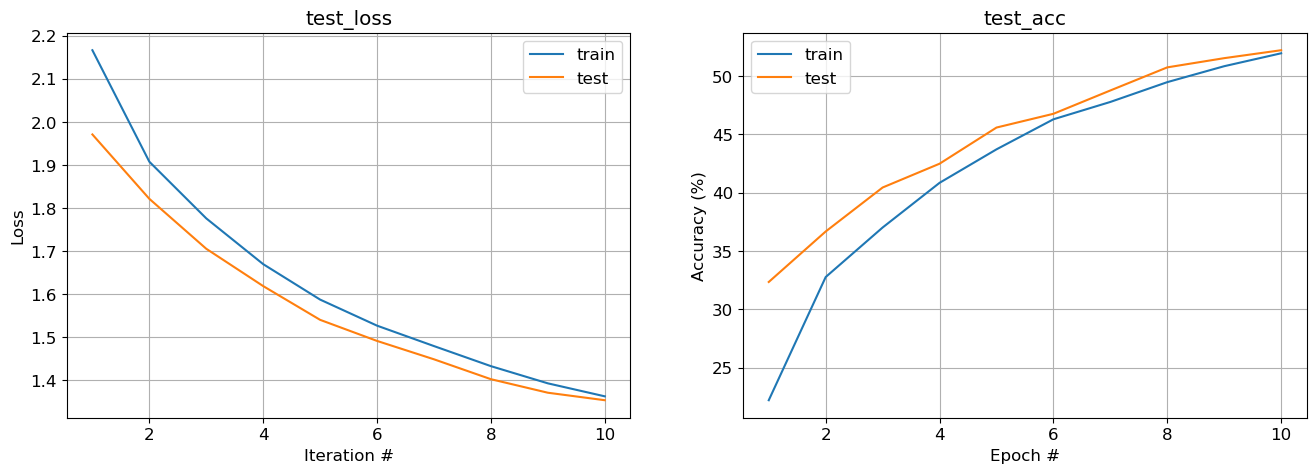

In [5]:
from hw2.experiments import load_experiment, cnn_experiment
from cs236781.plot import plot_fit

# Test experiment1 implementation on a few data samples and with a small model
cnn_experiment(
    'test_run', seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
    filters_per_layer=[32,64], layers_per_block=1, pool_every=1, hidden_dims=[100],
    model_type='resnet',
)

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment('results/test_run_L1_K32-64.json')
_, _ = plot_fit(fit_res, train_test_overlay=True)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)

We'll use the following function to load multiple experiment results and plot them together.

In [6]:
def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        m = re.match('exp\d_(\d_)?(.*)\.json', os.path.basename(filepath))
        cfg, fit_res = load_experiment(filepath)
        fig, axes = plot_fit(fit_res, fig, legend=m[2],log_loss=True)
    del cfg['filters_per_layer']
    del cfg['layers_per_block']
    print('common config: ', cfg)

#### Experiment 1.1: Varying the network depth (`L`)

First, we'll test the effect of the network depth on training.

**Configuratons**:
- `K=32` fixed, with `L=2,4,8,16` varying per run
- `K=64` fixed, with `L=2,4,8,16` varying per run

So 8 different runs in total.

**Naming runs**:
Each run should be named `exp1_1_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_1_L2_K32`. 

**TODO**: Run the experiment on the above configuration with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_1', 'out_dir': './results', 'seed': 1766847654, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.003, 'reg': 0.003, 'pool_every': 2, 'hidden_dims': [512], 'model_type': 'cnn', 'stride': 1, 'padding': 1, 'kernel_size': 3, 'dilation': 1, 'pooling_kernel_size': 2, 'pooling_stride': 2, 'lrelu_slope': 0.01, 'activation_type': 'lrelu', 'dropout': 0.1, 'batchnorm': False, 'bottleneck': False, 'amsgrad': False, 'kw': {}}


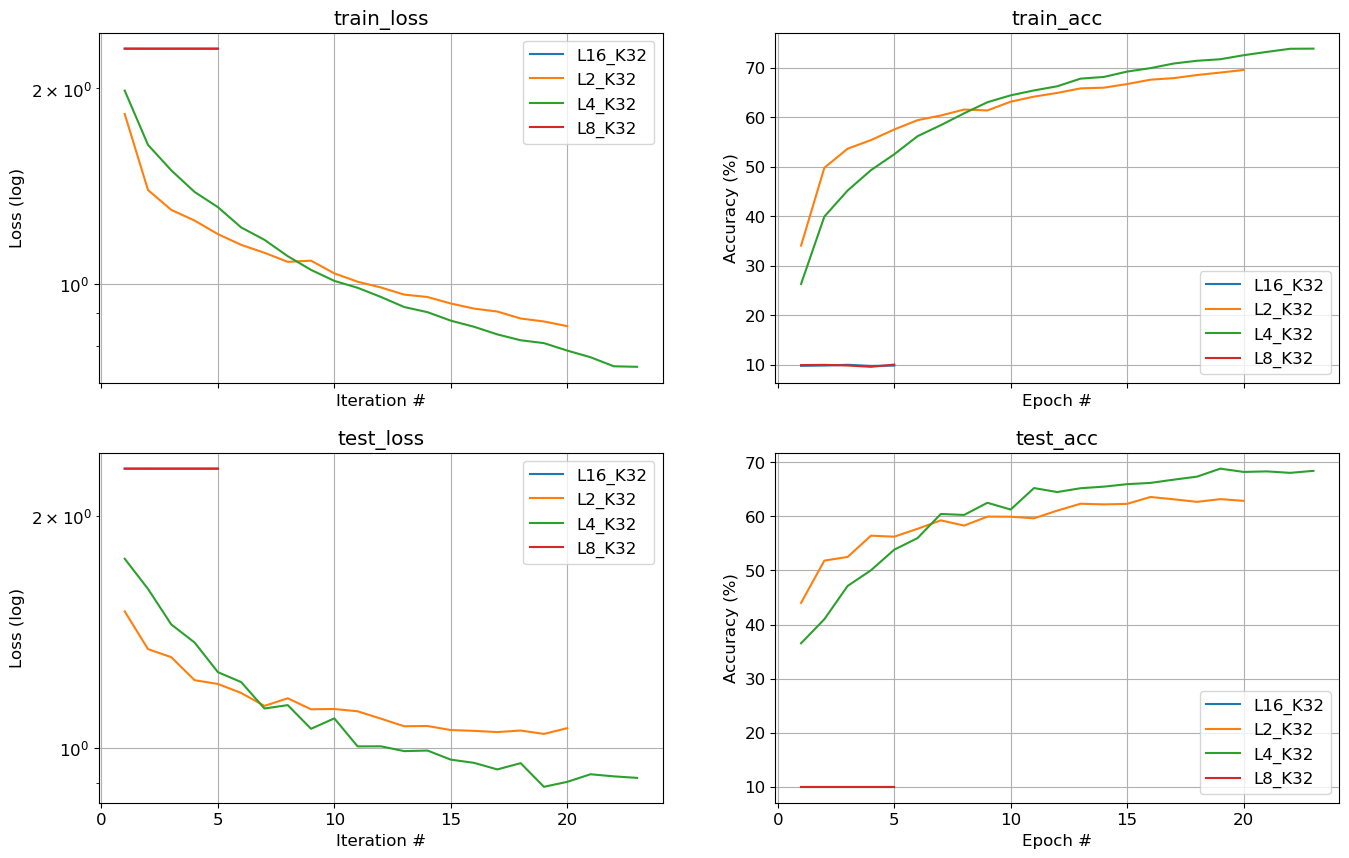

In [7]:
plot_exp_results('exp1_1_L*_K32*.json')

common config:  {'run_name': 'exp1_1', 'out_dir': './results', 'seed': 775983370, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.003, 'reg': 0.003, 'pool_every': 2, 'hidden_dims': [512], 'model_type': 'cnn', 'stride': 1, 'padding': 1, 'kernel_size': 3, 'dilation': 1, 'pooling_kernel_size': 2, 'pooling_stride': 2, 'lrelu_slope': 0.01, 'activation_type': 'lrelu', 'dropout': 0.1, 'batchnorm': False, 'bottleneck': False, 'amsgrad': False, 'kw': {}}


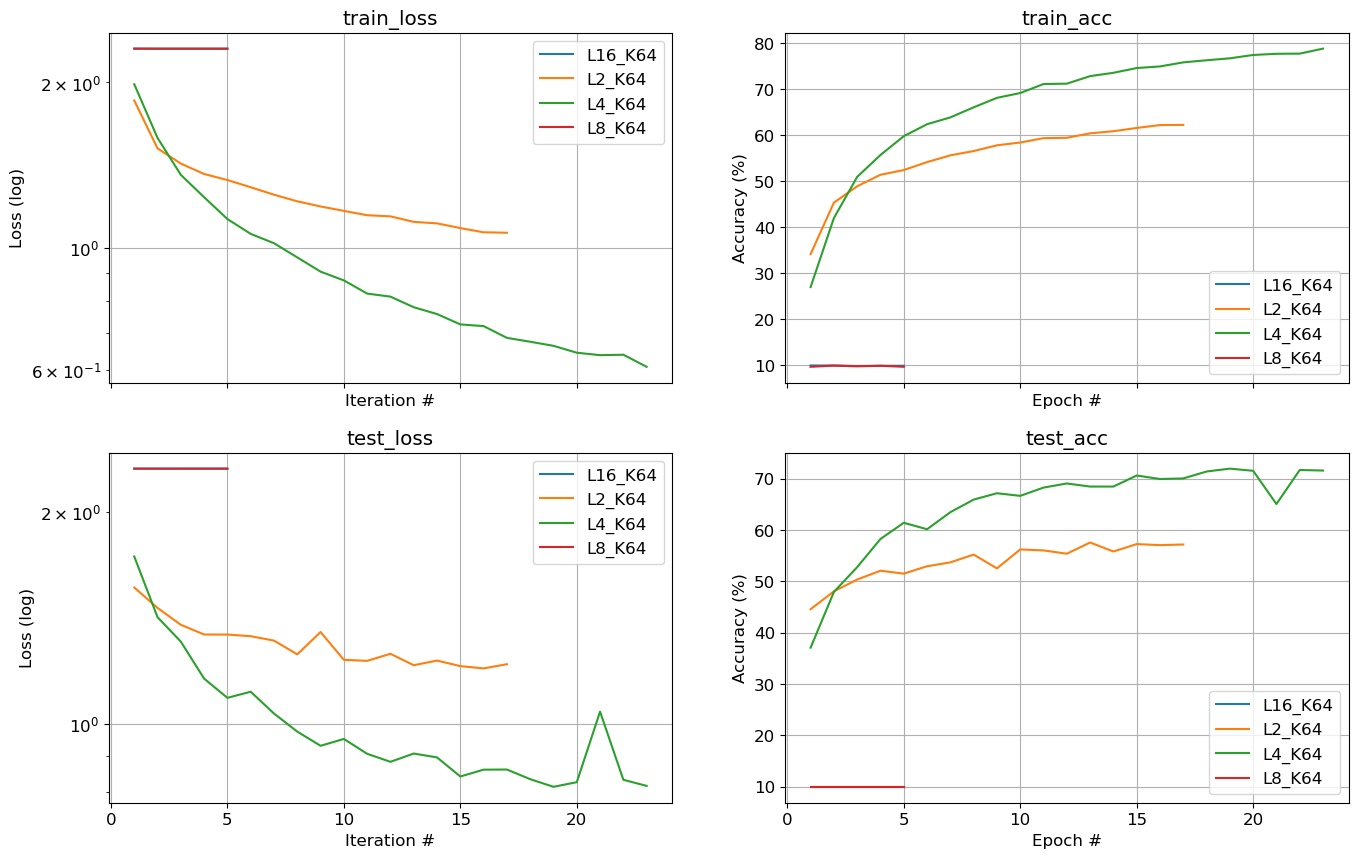

In [8]:
plot_exp_results('exp1_1_L*_K64*.json')

#### Experiment 1.2: Varying the number of filters per layer (`K`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `L=2` fixed, with `K=[32],[64],[128]` varying per run.
- `L=4` fixed, with `K=[32],[64],[128]` varying per run.
- `L=8` fixed, with `K=[32],[64],[128]` varying per run.

So 9 different runs in total. To clarify, each run `K` takes the value of a list with a single element.

**Naming runs**:
Each run should be named `exp1_2_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_2_L2_K32`. 

**TODO**: Run the experiment on the above configuration with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_2', 'out_dir': './results', 'seed': 1033039586, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.003, 'reg': 0.003, 'pool_every': 1, 'hidden_dims': [512], 'model_type': 'cnn', 'stride': 1, 'padding': 1, 'kernel_size': 3, 'dilation': 1, 'pooling_kernel_size': 2, 'pooling_stride': 2, 'lrelu_slope': 0.01, 'activation_type': 'lrelu', 'dropout': 0.1, 'batchnorm': False, 'bottleneck': False, 'amsgrad': False, 'kw': {}}


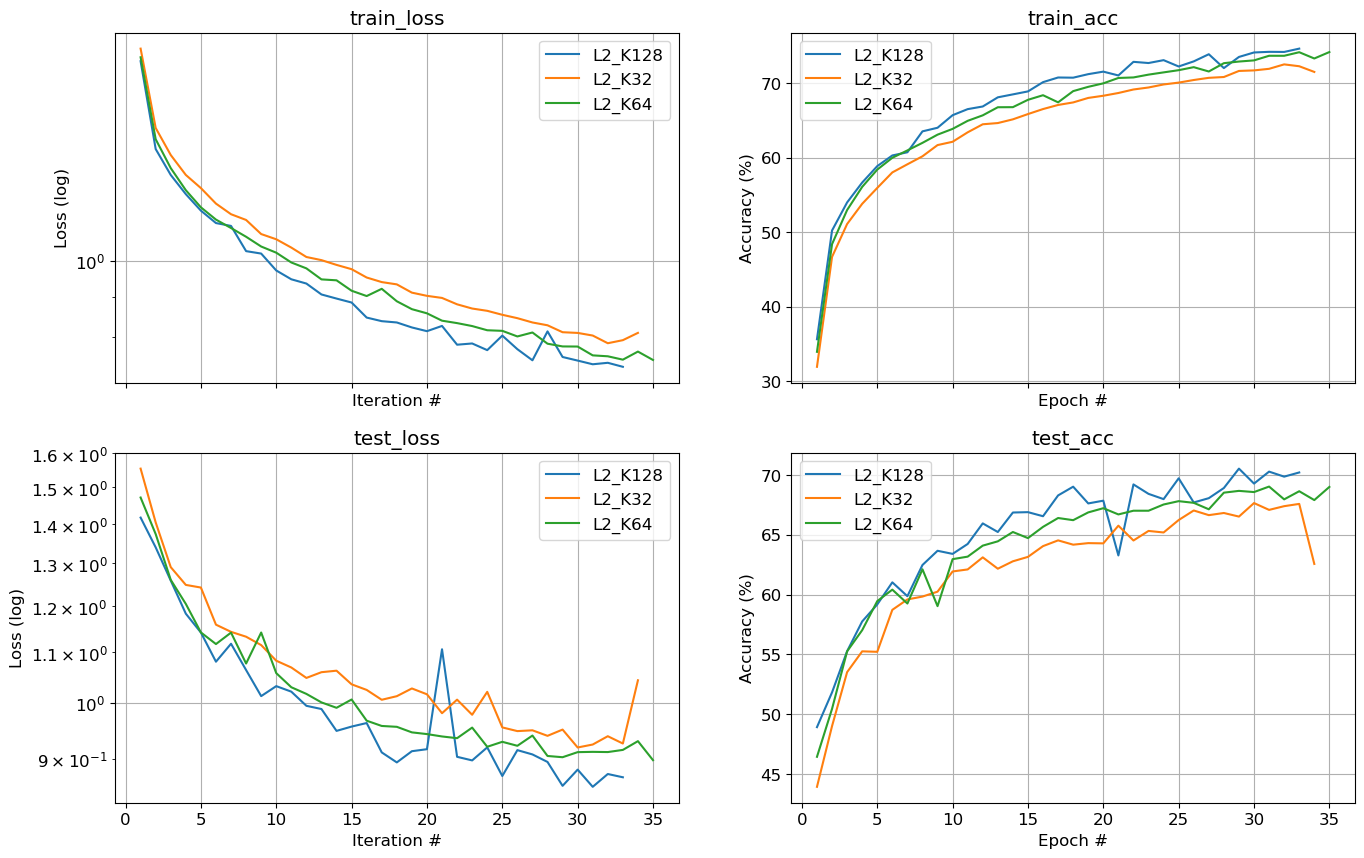

In [9]:
plot_exp_results('exp1_2_L2*.json')

common config:  {'run_name': 'exp1_2', 'out_dir': './results', 'seed': 1123547418, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.003, 'reg': 0.003, 'pool_every': 1, 'hidden_dims': [512], 'model_type': 'cnn', 'stride': 1, 'padding': 1, 'kernel_size': 3, 'dilation': 1, 'pooling_kernel_size': 2, 'pooling_stride': 2, 'lrelu_slope': 0.01, 'activation_type': 'lrelu', 'dropout': 0.1, 'batchnorm': False, 'bottleneck': False, 'amsgrad': False, 'kw': {}}


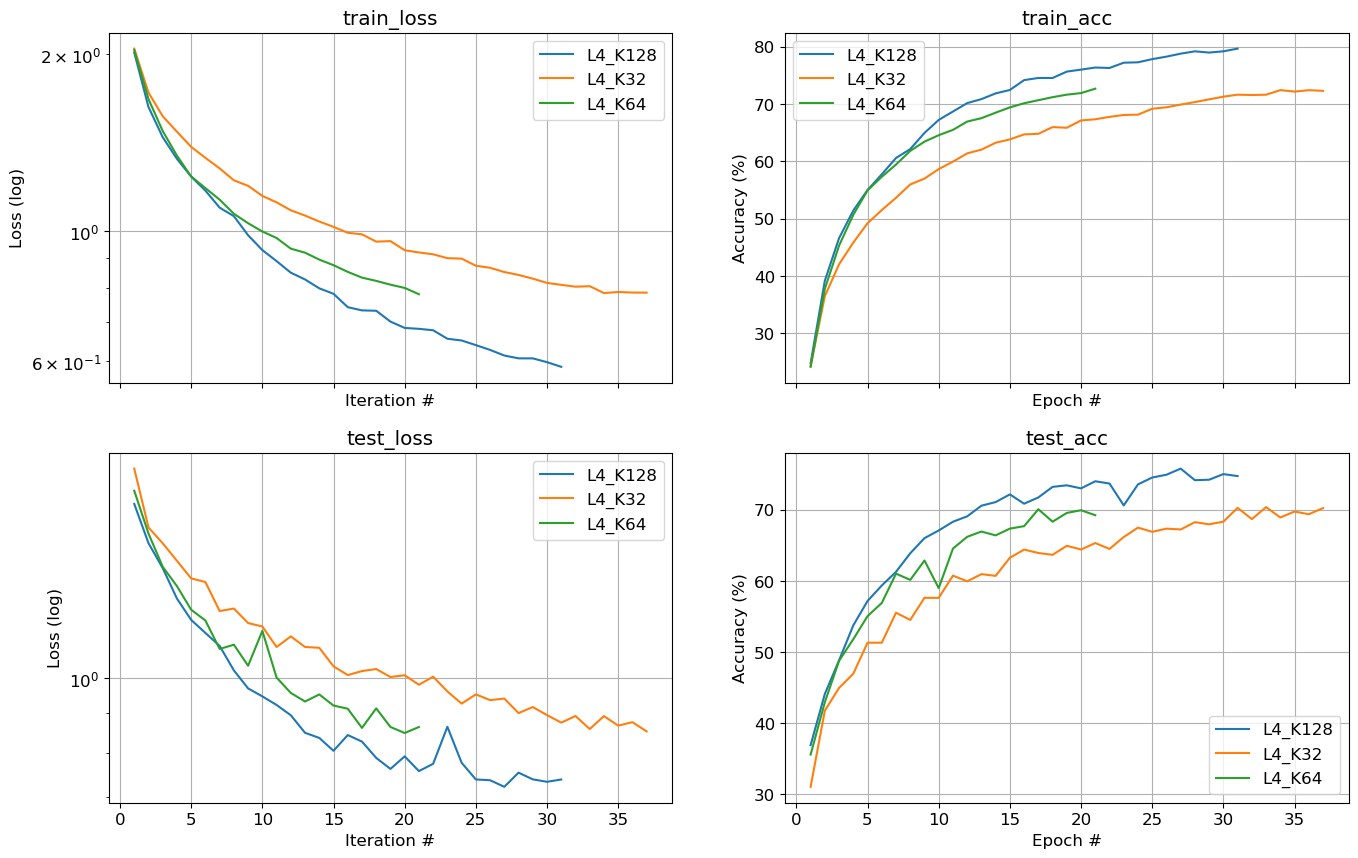

In [10]:
plot_exp_results('exp1_2_L4*.json')

common config:  {'run_name': 'exp1_2', 'out_dir': './results', 'seed': 155155554, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.003, 'reg': 0.03, 'pool_every': 9, 'hidden_dims': [256, 256, 256, 256], 'model_type': 'cnn', 'stride': 1, 'padding': 1, 'kernel_size': 3, 'dilation': 1, 'pooling_kernel_size': 2, 'pooling_stride': 2, 'lrelu_slope': 0.01, 'activation_type': 'lrelu', 'dropout': 0.1, 'batchnorm': False, 'bottleneck': False, 'amsgrad': False, 'kw': {}}


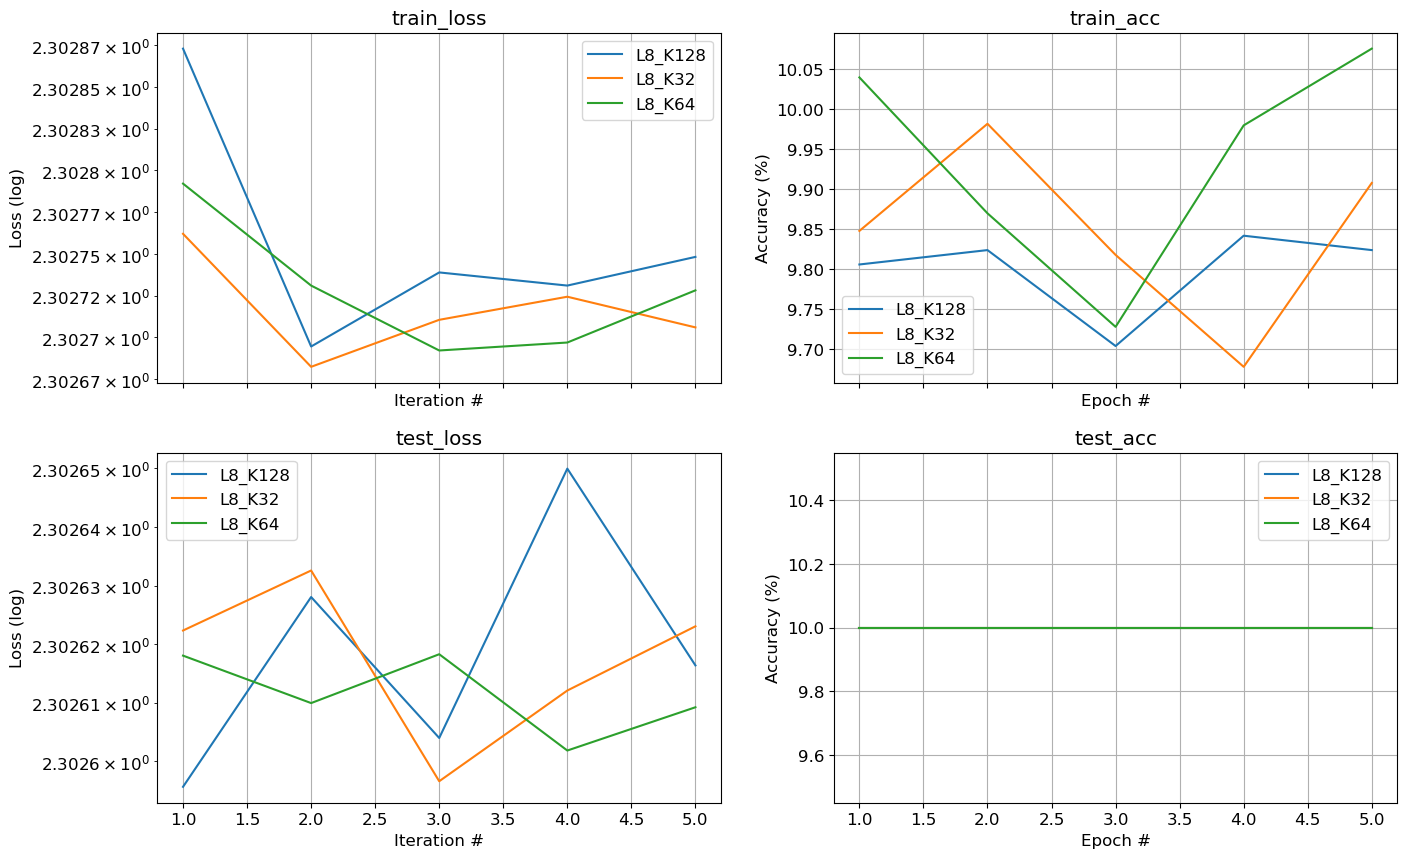

In [11]:
plot_exp_results('exp1_2_L8*.json')

#### Experiment 1.3: Varying both the number of filters (`K`) and network depth (`L`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `K=[64, 128]` fixed with `L=2,3,4` varying per run.

So 3 different runs in total. To clarify, each run `K` takes the value of an array with a two elements.

**Naming runs**:
Each run should be named `exp1_3_L{}_K{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_3_L2_K64-128`. 

**TODO**: Run the experiment on the above configuration  with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_3', 'out_dir': './results', 'seed': 1210900822, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 2, 'hidden_dims': [128], 'model_type': 'cnn', 'stride': 1, 'padding': 1, 'kernel_size': 3, 'dilation': 1, 'pooling_kernel_size': 2, 'pooling_stride': 2, 'lrelu_slope': 0.01, 'activation_type': 'lrelu', 'dropout': 0.1, 'batchnorm': False, 'bottleneck': False, 'amsgrad': False, 'kw': {}}


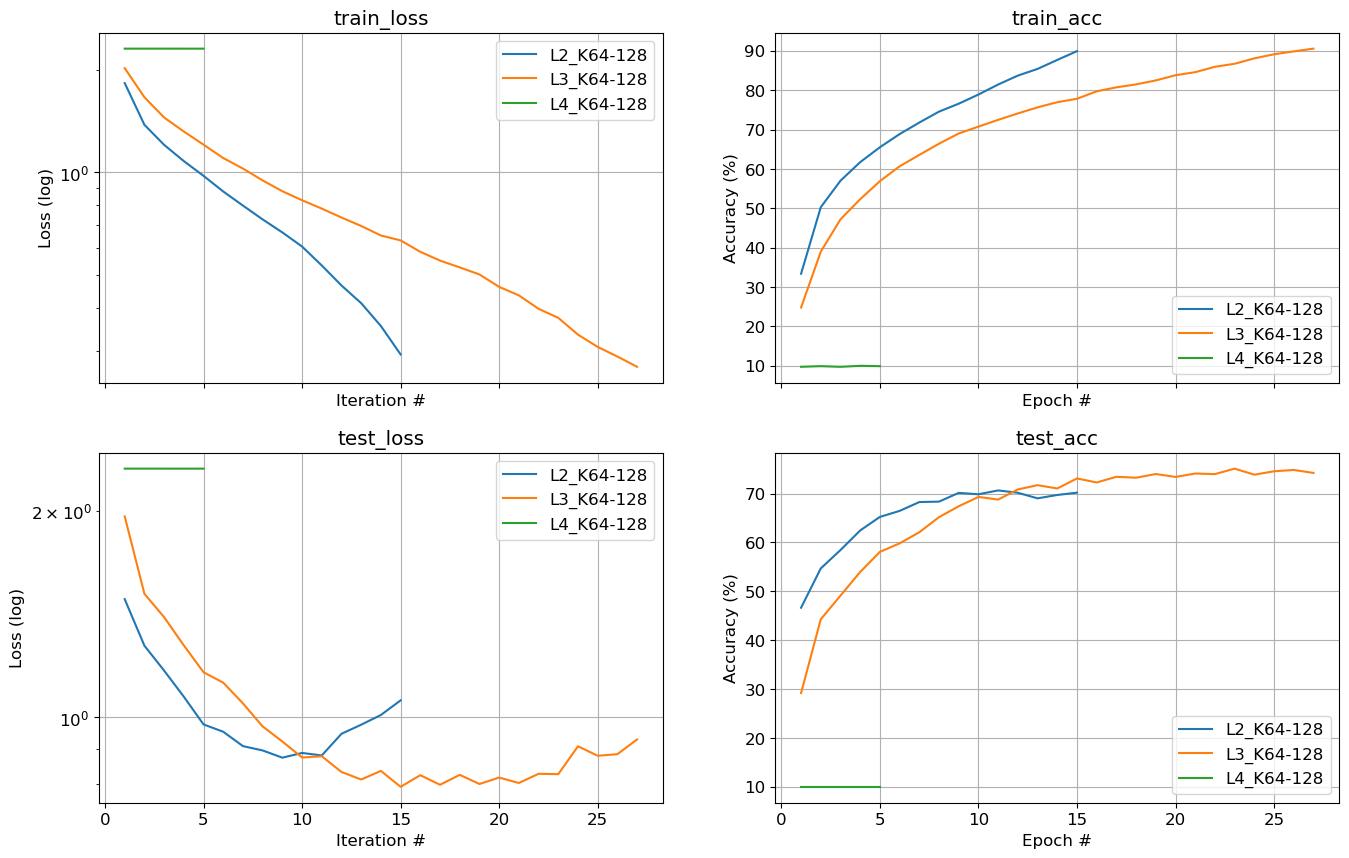

In [12]:
plot_exp_results('exp1_3*.json')

#### Experiment 1.4: Adding depth with Residual Networks

Now we'll test the effect of skip connections on the training and performance.

**Configuratons**:
- `K=[32]` fixed with `L=8,16,32` varying per run.
- `K=[64, 128, 256]` fixed with `L=2,4,8` varying per run.

So 6 different runs in total.

**Naming runs**:
Each run should be named `exp1_4_L{}_K{}-{}-{}` where the braces are placeholders for the values.

**TODO**: Run the experiment on the above configuration with the `ResNet` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_4', 'out_dir': './results', 'seed': 1779119314, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.004, 'reg': 0.001, 'pool_every': 2, 'hidden_dims': [512], 'model_type': 'resnet', 'stride': 1, 'padding': 1, 'kernel_size': 3, 'dilation': 1, 'pooling_kernel_size': 2, 'pooling_stride': 2, 'lrelu_slope': 0.01, 'activation_type': 'lrelu', 'dropout': 0.1, 'batchnorm': False, 'bottleneck': False, 'amsgrad': False, 'kw': {}}


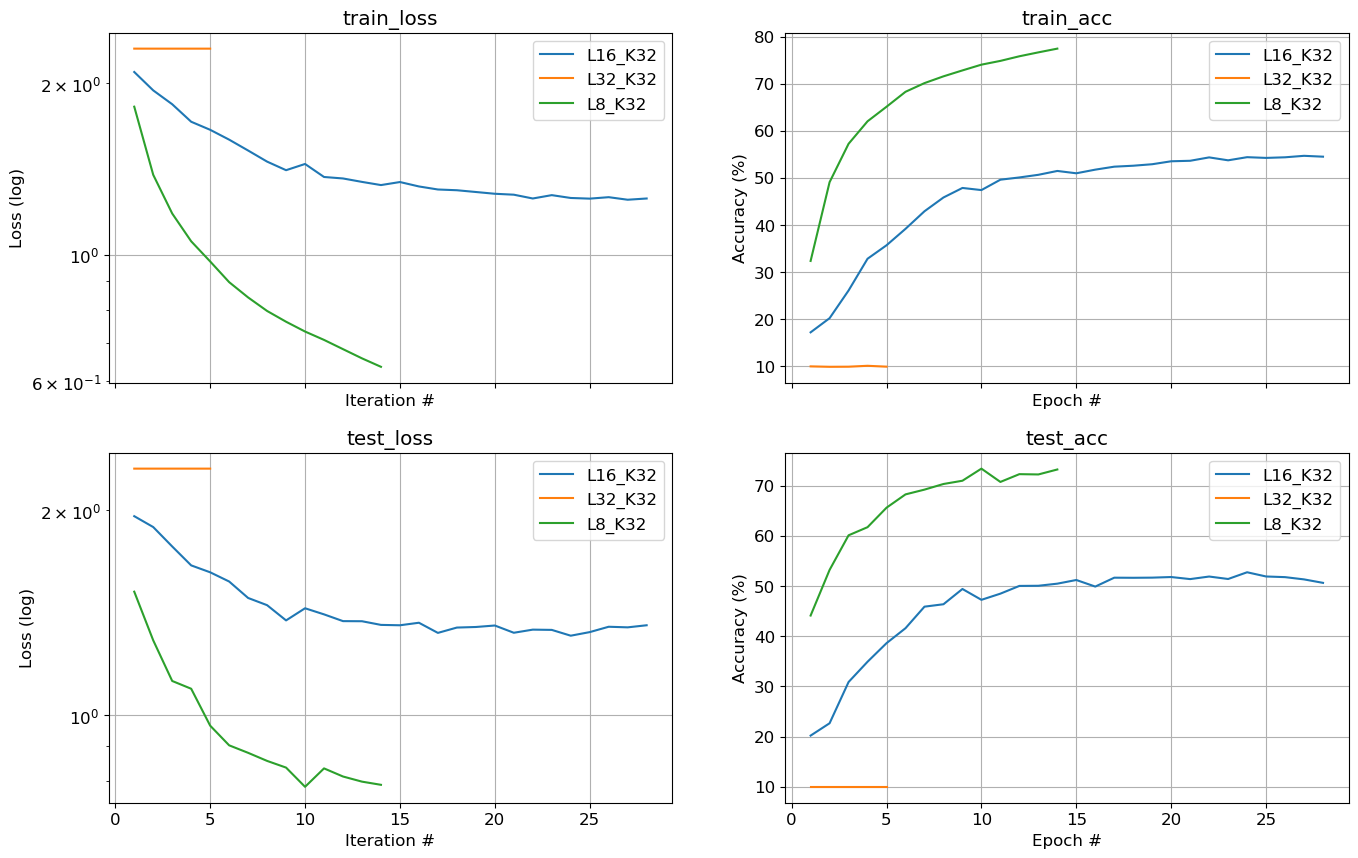

In [13]:
plot_exp_results('exp1_4_L*_K32.json')

common config:  {'run_name': 'exp1_4', 'out_dir': './results', 'seed': 1554481236, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.003, 'reg': 0.003, 'pool_every': 6, 'hidden_dims': [256, 256, 256, 256], 'model_type': 'resnet', 'kw': {}}


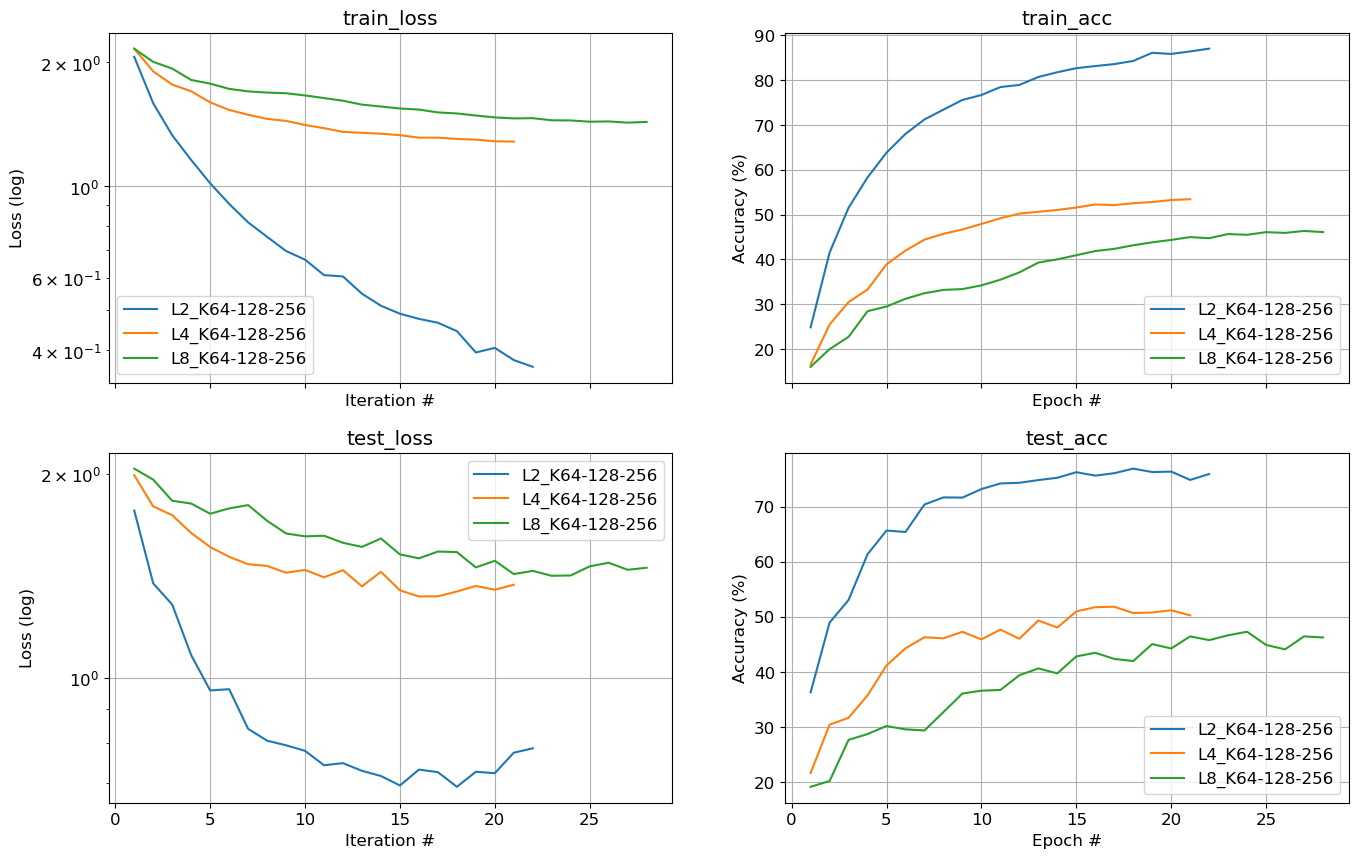

In [14]:
plot_exp_results('exp1_4_L*_K64*.json')

## Questions
<a id=part5_4></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.

In [15]:
from cs236781.answers import display_answer
import hw2.answers

### Question 1 

Analyze your results from experiment 1.1. In particular,
1.  Explain the effect of depth on the accuracy. What depth produces the best results and why do you think that's the case?
1. Were there values of `L` for which the network wasn't trainable? what causes this? Suggest two things which may be done to resolve it at least partially.

In [16]:
display_answer(hw2.answers.part5_q1)


**Your answer:**

1.1.

Analyzing the graphs, it becomes evident that increasing the network depth resulted in a decline in accuracy, best given by shallowest depths 2 and 4, and the depth of 4 yielded the best results for both k=32 and k=64.
a possible explanation could be overfitting: Deeper networks generally have a higher capacity to learn complex representations, but they are also more susceptible to overfitting. The depth of 4 may have been effective in preventing overfitting by striking a balance between capturing relevant features and avoiding excessive model complexity. By not going deeper, the network might have avoided overemphasizing noise or irrelevant patterns, leading to better generalization performance on your dataset.

1.2.

In our experiment, we encountered instances where the network became non-trainable for values of L=8 and L=16. This issue can be attributed to the problem of vanishing gradients, observed when the number of layers exceeds a certain threshold (in our case, above 4). The presence of vanishing gradients causes the gradients to diminish significantly, eventually reaching zero. This phenomenon hinders the model's ability to learn and make updates to its parameters.
To partially address the vanishing gradients problem, two potential solutions can be considered.
Firstly, the utilization of batch normalization can help alleviate this issue. By normalizing the input to each layer, ensuring zero mean and unit variance, the gradients are allowed to flow more smoothly throughout the network without vanishing.
Secondly, incorporating skip connections, inspired by the ResNet architecture, can also mitigate the vanishing gradients problem. By establishing direct connections that bypass upper layers and enable gradients to flow directly to lower layers, the network can maintain a more stable gradient flow during training. This approach promotes better information propagation and enables the model to learn effectively, even with larger values of L.



### Question 2 

Analyze your results from experiment 1.2. In particular, compare to the results of experiment 1.1.

In [17]:
display_answer(hw2.answers.part5_q2)


**Your answer:**

Upon analyzing the provided graphs, several observations can be made. First, for a fixed value of L, larger values of K tend to yield higher accuracy in both training and testing. Additionally, in the comparison between L=4 and L=2, L=4 consistently produces superior results.
Similar to the findings in experiment 1.1, we observe that for L=8 (where L>4), the network becomes non-trainable, resulting in extremely low accuracy across all varying values of K. This aligns with our previous understanding.
In comparison to the results from experiment 1.1, where the best performance was achieved with L=4 and K=32, the findings from experiment 1.2 demonstrate even better outcomes. Specifically, we achieve test accuracies surpassing 70% for L=4 and larger values of K such as K=128 and K=256.



### Question 3 

Analyze your results from experiment 1.3.

In [18]:
display_answer(hw2.answers.part5_q3)


**Your answer:**

Upon analyzing the graphs, it is evident that the model's performance varies with different values of L (depth). Interestingly, for this experiment, L=3, which corresponds to the second lowest depth, yields the highest test accuracy. This suggests that a moderate depth is optimal for achieving better results in terms of accuracy.

Furthermore, a notable observation is that the accuracy drastically drops for L=4. In previous experiments 1.1 and 1.2, such a significant drop in accuracy occurred only for larger values of L, such as L=8. This indicates the presence of the vanishing gradients phenomenon, where the gradients diminish exponentially as they propagate through the deeper layers of the network.



### Question 4

Analyze your results from experiment 1.4. Compare to experiment 1.1 and 1.3.

In [19]:
display_answer(hw2.answers.part5_q4)


**Your answer:**

Upon analyzing the provided graphs, it becomes evident that shallower depths yield better outcomes in terms of test accuracies. This observation aligns with our earlier findings in section 1.1 and nearly those of section 1.3 where the second lowest depth was ideal in term of accuracy.
When considering the ResNet architecture with a fixed value of K=32, we no longer observe the extremely low accuracy values associated with the vanishing gradients problem, as observed in section 1.1 for L>4 and in section 1.3 for L=4. This improvement is noticeable for L=8 and L=16, suggesting that the vanishing gradients issue has been mitigated to some extent. However, it is worth noting that for L=32, the phenomenon of vanishing gradients still persists.
Interestingly, for larger values of K (>32, such as K=64, 128, 512), and across depths L=2, 4, and 8, we successfully mitigate the vanishing gradients problem, as previously suggested.
Consequently, L=2 yields satisfactory results in terms of accuracy.

